# Train a deep Convolutional SNN on the DVS-Gestures dataset

In [1]:
# First, imports
import os
import sys

sys.path.append("../../")
import gc

import numpy as np
import torch

import matplotlib.pyplot as plt
import seaborn as sns

import stork.datasets
from stork.datasets import HDF5Dataset, DatasetView

from stork.models import RecurrentSpikingModel
from stork.nodes import InputGroup, ReadoutGroup, LIFGroup, MaxPool2d
from stork.connections import Connection, Conv2dConnection
from stork.generators import StandardGenerator
from stork.initializers import (
    FluctuationDrivenCenteredNormalInitializer,
    DistInitializer,
)
from stork.layers import ConvLayer

import tonic

## Load dataset

If necessary, adjust the path to the dataset. We use the `tonic` library to access the DVS-Gestures dataset. If not already there, the dataset will be downloaded and extracted to the specified path.

In [2]:
datadir = "./data/datasets"

In [3]:
# DATASET PARAMETERS

target_size = 32  # downscale to 32x32
input_size = [2, target_size, target_size]
nb_classes = 11
duration = 1.0  # 1 second
time_step = dt = 2e-3
nb_time_steps = int(duration / time_step)
dropevent_p = 0.5
bool_spiketrain = False  # Whether to call a boolean operation on the spiketrain
# (Prevents spikes with an amplitude >1)

# Transforms

# Drop random events
tf_dropevent = tonic.transforms.DropEvent(p=dropevent_p)

# Convert to milliseconds
tf_convert_to_ms = tonic.transforms.Downsample(
    time_factor=1e-3, spatial_factor=target_size / 128
)

# Assemble frames according to timestep
tf_frame = tonic.transforms.ToFrame(
    sensor_size=(target_size, target_size, 2), time_window=time_step * 1000
)

# CUSTOM TRANSFORMS


class ToTensorTransform:
    """Custom ToTensor transform that supports 4D arrays"""

    def __init__(self, bool_spiketrain=False):
        self.bool_spiketrain = bool_spiketrain

    def __call__(self, x):
        if self.bool_spiketrain:
            return torch.as_tensor(x).bool().float()
        else:
            return torch.as_tensor(x).float()


tf_tensor = ToTensorTransform(bool_spiketrain)


class TimeCropTransform:
    """Custom transform that randomly crops the time dimension"""

    def __init__(self, timesteps):
        self.timesteps = int(timesteps)

    def __call__(self, x):
        start = np.random.randint(0, high=x.shape[0] - self.timesteps)
        return x[start : start + self.timesteps, :, :, :]


tf_timecrop = TimeCropTransform(nb_time_steps)

all_transforms = tonic.transforms.Compose(
    [tf_dropevent, tf_convert_to_ms, tf_frame, tf_tensor, tf_timecrop]
)

train_dataset = tonic.datasets.DVSGesture(datadir, train=True, transform=all_transforms)

test_dataset = tonic.datasets.DVSGesture(datadir, train=False, transform=all_transforms)

## Set up the model

In [4]:
# Model Parameters
# # # # # # # # # # #

beta = 20
nb_conv_blocks = 2  # Each block features two conv layers
# followed by a max pooling layer
nb_filters = [16, 32]  # Number of features per layer
kernel_size = 3  # Convolutional operation parameters
stride = 1
padding = 2

maxpool_kernel_size = 2  # Max pooling operation parameters
dropout_p = 0.0  # Dropout probability

# Neuron Parameters
# # # # # # # # # # #

neuron_group = LIFGroup
tau_mem = 20e-3
tau_syn = 10e-3
tau_readout = duration

# Training parameters
# # # # # # # # # # #

batch_size = 16
device = torch.device("cuda")
dtype = torch.float
lr = 5e-3
nb_epochs = 20

#### SuperSpike / Loss function

In [5]:
act_fn = stork.activations.SuperSpike
act_fn.beta = beta

loss_stack = stork.loss_stacks.MaxOverTimeCrossEntropy()

#### Optimizer

In [6]:
opt = stork.optimizers.SMORMS3
generator = StandardGenerator(nb_workers=4)

#### Regularizer

In [7]:
# Define regularizer parameters (set regularizer strenght to 0 if you don't want to use them)
upperBoundL2Strength = 0.01
upperBoundL2Threshold = 10

# Define regularizer list
regs = []

regUB = stork.regularizers.UpperBoundL2(
    upperBoundL2Strength, threshold=upperBoundL2Threshold, dims=[-2, -1]
)
regs.append(regUB)

In [8]:
sigma_u = 1.0
nu = 9.2

initializer = FluctuationDrivenCenteredNormalInitializer(
    sigma_u=sigma_u,
    nu=nu,
    timestep=dt,
)

readout_initializer = DistInitializer(
    dist=torch.distributions.Normal(0, 1), scaling="1/sqrt(k)"
)

#### Assemble the model

In [9]:
model = RecurrentSpikingModel(batch_size, nb_time_steps, input_size, device, dtype)
# INPUT LAYER
# # # # # # # # # # # # # # #
input_group = model.add_group(InputGroup(input_size))

# Set input group as upstream of first hidden layer
upstream_group = input_group

# HIDDEN LAYERS
# # # # # # # # # # # # # # #
neuron_kwargs = {"tau_mem": 20e-3, "tau_syn": 10e-3, "activation": act_fn}

for block_idx in range(nb_conv_blocks):
    # Generate Layer name and config
    block_name = str("Block") + " " + str(block_idx + 1)

    # Make conv layers
    for conv_idx in range(2):
        conv = ConvLayer(
            name=block_name + " Conv" + str(conv_idx + 1),
            model=model,
            input_group=upstream_group,
            kernel_size=kernel_size,
            stride=stride,
            padding=padding,
            nb_filters=nb_filters[block_idx],
            recurrent=False,
            neuron_class=neuron_group,
            neuron_kwargs=neuron_kwargs,
            regs=regs,
            connection_class=Conv2dConnection,
        )

        # Initialize Parameters
        initializer.initialize(conv)

        # Set output as input to next layer
        upstream_group = conv.output_group

    # Make maxpool layer
    maxpool = model.add_group(
        MaxPool2d(upstream_group, kernel_size=maxpool_kernel_size, dropout_p=dropout_p)
    )

    upstream_group = maxpool


# READOUT LAYER
# # # # # # # # # # # # # # #
readout_group = model.add_group(
    ReadoutGroup(
        nb_classes,
        tau_mem=tau_readout,
        tau_syn=neuron_kwargs["tau_syn"],
        initial_state=-1e-3,
    )
)

readout_connection = model.add_connection(
    Connection(upstream_group, readout_group, flatten_input=True)
)

# Initialize readout connection
readout_initializer.initialize(readout_connection)

#### Configure model for training

In [10]:
model.configure(
    input=input_group,
    output=readout_group,
    loss_stack=loss_stack,
    generator=generator,
    optimizer=opt,
    optimizer_kwargs=dict(lr=lr),
    time_step=dt,
)

## Training

In [11]:
results = {}

history = model.fit(train_dataset, nb_epochs=nb_epochs, verbose=True)

results["train_loss"] = history["loss"].tolist()
results["train_acc"] = history["acc"].tolist()

00  loss=2.5 reg_loss=0.684 acc=0.165 t_iter=73.86
01  loss=2.15 reg_loss=0.0379 acc=0.212 t_iter=71.56
02  loss=2.04 reg_loss=0.00375 acc=0.257 t_iter=72.89
03  loss=1.91 reg_loss=0.000695 acc=0.297 t_iter=72.15
04  loss=1.87 reg_loss=0.000555 acc=0.298 t_iter=71.32
05  loss=1.88 reg_loss=0.00034 acc=0.326 t_iter=73.01
06  loss=1.83 reg_loss=0.000304 acc=0.345 t_iter=73.34
07  loss=1.74 reg_loss=9.07e-05 acc=0.381 t_iter=72.71
08  loss=1.62 reg_loss=0.000142 acc=0.441 t_iter=71.47
09  loss=1.27 reg_loss=0.000141 acc=0.557 t_iter=72.18
10  loss=1.02 reg_loss=0.000105 acc=0.651 t_iter=71.71
11  loss=0.929 reg_loss=0.000335 acc=0.665 t_iter=72.02
12  loss=0.81 reg_loss=0.000224 acc=0.723 t_iter=72.37
13  loss=0.61 reg_loss=0.000264 acc=0.806 t_iter=73.06
14  loss=0.354 reg_loss=0.000347 acc=0.903 t_iter=71.81
15  loss=0.227 reg_loss=0.000315 acc=0.944 t_iter=72.07
16  loss=0.185 reg_loss=0.000348 acc=0.951 t_iter=72.56
17  loss=0.171 reg_loss=0.000301 acc=0.95 t_iter=72.63
18  loss=0.155

## Test

In [44]:
# Free up some GPU space and clear cache
# This might not be necessary for you if your GPU has enough memory
del history
gc.collect()
torch.cuda.empty_cache()

In [45]:
# Change batch size to 4 for testing
# Again, just for memory reasons

model.batch_size = 4
model.data_generator_.configure(
    model.batch_size,
    model.nb_time_steps,
    model.nb_inputs,
    model.time_step,
    device=model.device,
    dtype=model.dtype,
)

In [46]:
scores = model.evaluate(test_dataset).tolist()
results["test_loss"], _, results["test_acc"] = scores

Test loss:  0.6598869568124153
Test acc.:  0.8446969696969697


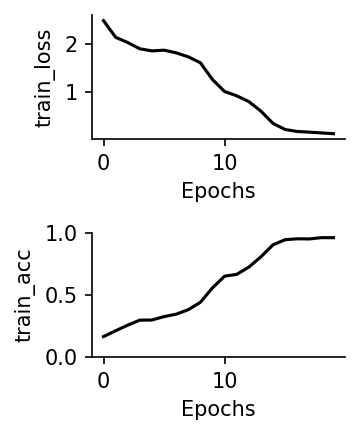

In [47]:
fig, ax = plt.subplots(2, figsize=(2.5, 3), dpi=150)

for i, n in enumerate(["train_loss", "train_acc"]):
    a = ax[i]

    a.plot(results[n], color="black")
    a.set_xlabel("Epochs")
    a.set_ylabel(n)

ax[-1].set_ylim(0, 1)
sns.despine()
plt.tight_layout()

print("Test loss: ", results["test_loss"])
print("Test acc.: ", results["test_acc"])